# Emerging Topics final code

This code was created from Martha and Sean's emerging topic code and was used to create the hottest/coldest topics static graphics for the full, pandemics, and coronavirus corpora.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
#import gensim
import time

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import seaborn as sns

import statsmodels.api as sm

### Data Ingestion

In [2]:
# full corpus
df = pd.read_pickle("../../data/final/final_dataset_7-20.pkl")

# pandemic corpus
#df = pd.read_pickle("../../data/final/dashboard_data/pandemic_corpus.pkl")
#df.reset_index(inplace=True)

# coronavirus corpus
#df = pd.read_pickle("../../data/final/dashboard_data/corona_corpus.pkl")
#df.reset_index(inplace=True)

In [3]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []
docs = df["final_frqwds_removed"]

for abstract in docs:
    text.append(" ".join(abstract))

### Functions needed for all models

In [4]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [5]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF
- Optimal Model: full dataset, 75 topics, random_state = 14
- Pandemic Model: pandemic dataset, 30, random_state = 1
- Coronavirus Model: coronavirus dataset, 30, random_state = 1

In [6]:
# use for full dataset
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, max_features=int(len(docs)/2))
tf_idf = tfidf_vectorizer.fit_transform(text)

# use for pandemic or coronavirus dataset
#tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False)
#tf_idf = tfidf_vectorizer.fit_transform(text)


In [ ]:
# create model

num_topics = 30 

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

topic_term = nmf_model.components_

In [ ]:
#print_topics(nmf_model, tfidf_vectorizer, 10)

In [ ]:
# save nmf model on full dataset

#pickle.dump(nmf_model, open('full_nmf75.sav', 'wb'))


In [ ]:
# read in model

#nmf_model = pickle.load(open('full_nmf75.sav', 'rb'))


In [7]:
# full dataset model ingestion so do not have to rerun

num_topics = 75

doc_topic, topic_term = pickle.load(open('../../data/final/opt_NMF_model/final_model_DT_TT.sav','rb'))

### Emerging Topics

In [8]:
# Extract Year from PROJECT_START_DATE

#On our graphs, we want to be able to show year. Therefore, this getYear function gets the year from different date formats from Project Start Year/End Year

#START

def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year

df['START_YEAR'] = df['PROJECT_START_DATE'].apply(getYear)

In [ ]:
df["START_YEAR"].value_counts()

In [ ]:
df.dtypes

In [9]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["START_YEAR"] = df["START_YEAR"]


In [10]:
topic_frame_se = topic_frame.groupby("START_YEAR").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "START_YEAR")
topic_frame_se["START_YEAR"] = topic_frame_se["START_YEAR"].astype(int)

topic_wts_se_2010_2019 = topic_frame_se[topic_frame_se["START_YEAR"] > 2009] 
topic_wts_se_2010_2019 = topic_wts_se_2010_2019[topic_wts_se_2010_2019["START_YEAR"] < 2020] 

In [ ]:
topic_wts_se_2010_2019

In [11]:
topic_frame = topic_frame.groupby("START_YEAR").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "START_YEAR")
topic_frame["START_YEAR"] = topic_frame["START_YEAR"].astype(int)

In [ ]:
topic_frame.head()

In [12]:
# filter topic_frame for years 2010 - 2019

topic_wts_2010_2019 = topic_frame[topic_frame["START_YEAR"] > 2009] 
topic_wts_2010_2019 = topic_wts_2010_2019[topic_wts_2010_2019["START_YEAR"] < 2020] 

In [ ]:
topic_wts_2010_2019

In [13]:
topic_slopes = []
topic_slopes_se = []

lm_x = topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1)
lm_x = sm.add_constant(lm_x)

for i in range(1,num_topics+1):

    linear_fit = sm.OLS(topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1),lm_x).fit()
    
    topic_slopes.append(linear_fit.params[1])
    topic_slopes_se.append(linear_fit.bse[1])
    

In [ ]:
# save coefs and SEs of emerging topics regressions
emerging_topics_results = pd.DataFrame(
    {"Topic": [str(i) for i in range(num_topics)],
     "Topic slope": topic_slopes, 
     "Topic slope SE": topic_slopes_se
    })
emerging_topics_results.to_csv("results/full_results.csv", index=False)

In [ ]:
# perform regressions, track slopes

#topic_slopes = []

#for i in range(1,num_topics+1):
#    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    
#    topic_slopes.append(linear_fit.coef_[0][0])

In [ ]:
topic_slopes[:5]

In [14]:
hot_cold = []

for slope in topic_slopes:
    if slope > 0:
        hot_cold.append("hot")
    else:
        hot_cold.append("cold")

In [ ]:
hot_cold[:5]

In [ ]:
topic_words = str_topics(topic_term, tfidf_vectorizer, top_n=10)

In [ ]:
topic_words[:5]

In [ ]:
# package up data for data table in RShiny dashboard

reg_topics = pd.DataFrame()
reg_topics["Slope"] = topic_slopes
reg_topics["Hot or Cold"] = hot_cold
reg_topics["Topic Words"] = topic_words 


In [ ]:
reg_topics

In [ ]:
#reg_topics.to_csv("./full_topics.csv", index=False)
#reg_topics.to_csv("./pan_topics.csv", index=False)
#reg_topics.to_csv("./cor_topics.csv", index=False)

## Create plots - top 5 hot and cold topics, static plots

In [ ]:
topic_wts_2010_2019

In [15]:
# Sean's plots - legend

leg = str_topics(topic_term, tfidf_vectorizer, top_n=5)

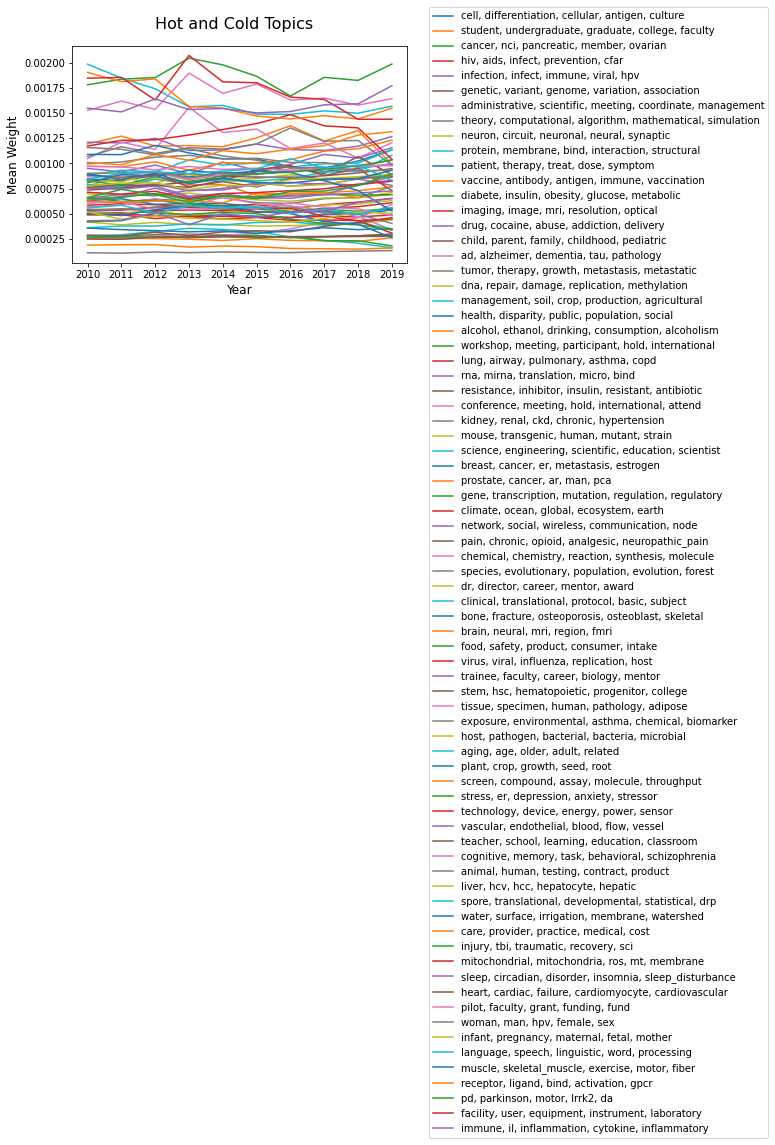

In [16]:
#Make Graphs
#leg = []
topic_results = {}
fig = plt.figure()
fig.suptitle('Hot and Cold Topics', fontsize=16)
ax = fig.add_subplot(111)

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    topic_results[i] = linear_fit.coef_[0][0]
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,i])
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Weight', fontsize=12)
#ax.yaxis.set_label_coords(-0.14,0.5)
plt.legend(leg,bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()

In [17]:
class HandlerDashedLines(HandlerLineCollection):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines


In [ ]:
# {column index, slope} - ex) 1: Topic 0 because Topic 0 is column 1 in the dataframe

#topic_results

In [18]:
def sort_dict(x):
    return sorted(x.items(), key=lambda l: l[1], reverse=True)

In [19]:
sort_slopes = sort_dict(topic_results)
top_slopes = [x[0] for x in sort_slopes[:5]]
bottom_slopes = [x[0] for x in sort_slopes[-5:]]

In [ ]:
sort_slopes[:5]

In [ ]:
top_slopes

In [ ]:
bottom_slopes

In [20]:
# get SE of weights

topic_wts_se_2010_2019 = topic_wts_se_2010_2019.drop(columns=['START_YEAR'])

## plot hottest and coldest on same plot

In [21]:
# for plotting hot and cold on same graph

topnbot_slopes = top_slopes + bottom_slopes

In [ ]:
topnbot_slopes

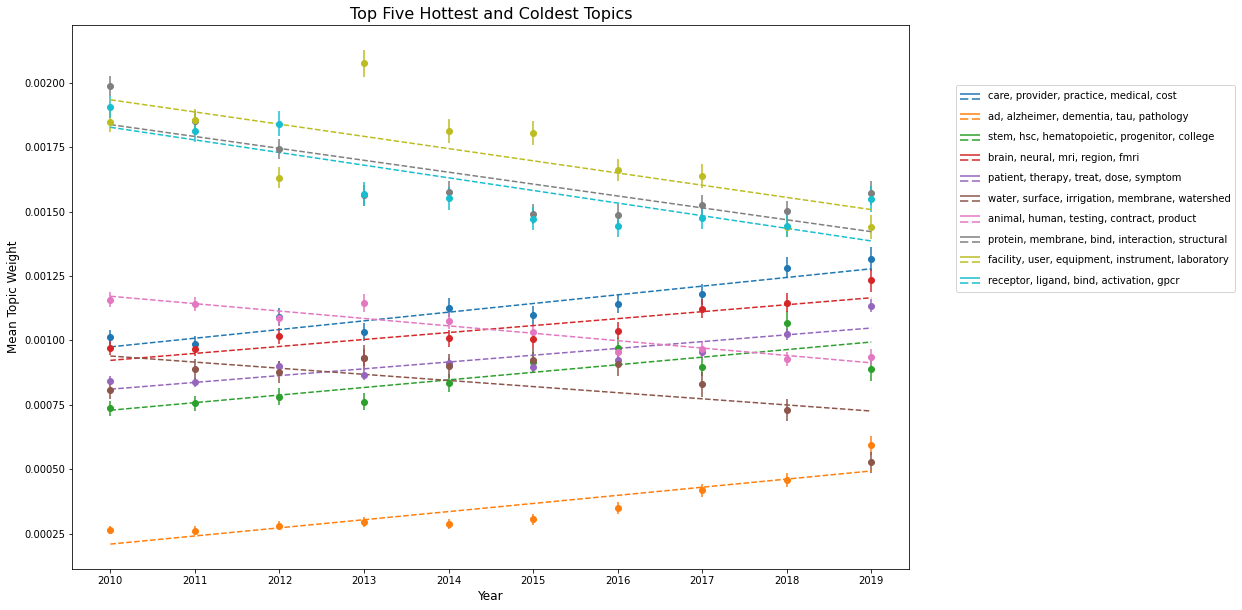

In [22]:
# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]


line_return = []
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
line = [[(0, 0)]]
i = 0
for n in topnbot_slopes:
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    #ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o')
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = 1.96 * np.array(topic_wts_se_2010_2019.iloc[:,n-1]), fmt = "o")
    line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Topic Weight', fontsize=12)
#plt.ylim(bottom = -0.001, top = 0.05)
plt.title('Top Five Hottest and Coldest Topics', fontsize=16)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
plt.legend(line_return, [leg[x-1] for x in topnbot_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

#plt.legend([leg[x] for x in top_slopes],bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("figures/full_hot_cold_topics.png", dpi = 800)
plt.show()

## Plot hottest and coldest topics on separate plots

In [ ]:
# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]


line_return = []
fig = plt.figure(figsize=(15,10))
fig.suptitle('Top Five Hottest Pandemics Topics', fontsize=16)
ax = fig.add_subplot(111)
line = [[(0, 0)]]
i = 0
for n in top_slopes:
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    #ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o')
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
                yerr = 1.96 * np.array(topic_wts_se_2010_2019.iloc[:,n-1]), fmt = "o")
    line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Weight', fontsize=12)
#plt.ylim(bottom = -0.002, top = 0.055)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
plt.legend(line_return, [leg[x-1] for x in top_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

#plt.legend([leg[x] for x in top_slopes],bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("figures/pandemics_hot_topics.png", dpi = 800)
plt.show()


#Make Graphs
#leg = []

#bottom_slopes.reverse()  # so the plot legend has the coldest listed first

line_return = []
fig = plt.figure(figsize=(15,10))
fig.suptitle('Top Five Coldest Pandemics Topics', fontsize=16)
ax = fig.add_subplot(111)
i = 0
for n in bottom_slopes:
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i+5])
    #ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color=color_list[i+5])
    #ax.scatter(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], color=color_list[i+5])
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
                yerr = 1.96 * np.array(topic_wts_se_2010_2019.iloc[:,n-1]), fmt = "o",
                color=color_list[i+5])
    line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i+5],color_list[i+5]]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Weight', fontsize=12)
#plt.ylim(bottom = -0.002, top = 0.055)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
plt.legend(line_return, [leg[x-1] for x in bottom_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

#plt.legend([leg[x] for x in top_slopes],bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("figures/pandemics_cold_topics.png", dpi = 800)
plt.show()

In [ ]:
bottom_slopes

In [ ]:
[leg[x-1] for x in bottom_slopes]

In [ ]:
# save model matrices if needed later

# save to file
topic_term = nmf_model.components_

pickle.dump([doc_topic, topic_term], open('final_model_DT_TT.sav','wb'))

In [ ]:
#Melt to get the data for graphing purposes 
#topic_df = topic_frame.melt(id_vars =['START_YEAR'], var_name = "Topic", value_name = "Weight")